In [158]:
import pandas as pd

# Load data
df = pd.read_csv("fake_LCICM_bp_data.csv")

# Ensure blood_pressure is numeric
df['blood_pressure'] = pd.to_numeric(df['blood_pressure'], errors='coerce')

# Calculate overall mean (ignoring NaNs)
dist_mean = df['blood_pressure'].mean()

# Count number of rows for each pat_id
pat_counts = df['pat_id'].value_counts()

# Compute per-patient means
pat_means = df.groupby('pat_id')['blood_pressure'].mean()

# Function to fill NaNs as specified
def fill_bp(row):
    if pd.notnull(row['blood_pressure']):
        return row['blood_pressure']
    count = pat_counts[row['pat_id']]
    # If patient has more than 1 row, use their mean; else, use overall mean
    if count > 1:
        return pat_means[row['pat_id']]
    else:
        return dist_mean

# Apply function to fill missing blood_pressure values
df['blood_pressure'] = df.apply(fill_bp, axis=1)

# Drop timestamp column if it exists
if 'timestamp' in df.columns:
    df = df.drop(columns=['timestamp'])

# Now group by pat_id and take mean blood pressure for the final DataFrame
result_df = df.groupby('pat_id', as_index=False)['blood_pressure'].mean()

print(result_df.head())


   pat_id  blood_pressure
0       0      144.000000
1       1       89.800000
2       2      101.120141
3       4       78.666667
4       5      131.666667


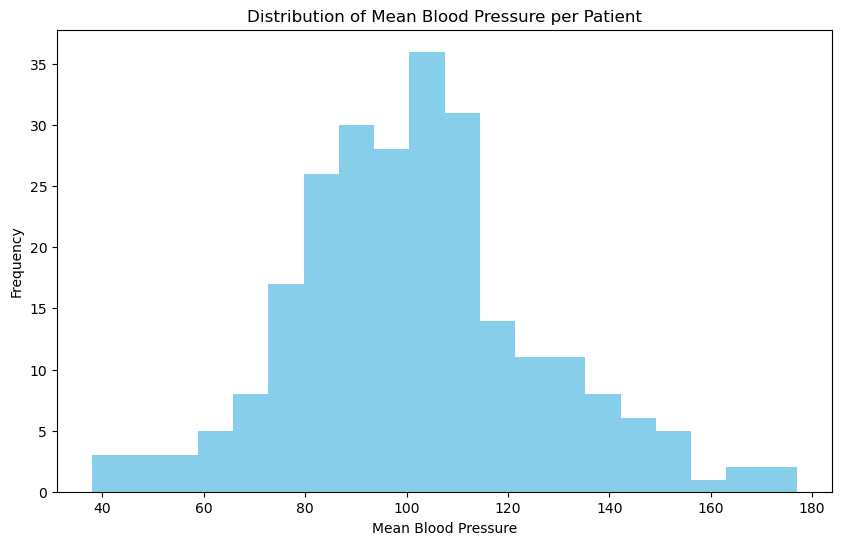

In [159]:
import matplotlib.pyplot as plt

# Plot histogram of the 'mean_blood_pressure' column
result_df['blood_pressure'].hist(bins=20, grid=False, figsize=(10,6), color='skyblue')

# Add title and labels
plt.title('Distribution of Mean Blood Pressure per Patient')
plt.xlabel('Mean Blood Pressure')
plt.ylabel('Frequency')

# Show the plot
plt.show()


In [160]:
# Calculate mean and standard deviation of mean_blood_pressure
mean_val = result_df['blood_pressure'].mean()
std_val = result_df['blood_pressure'].std()

# Define thresholds at z = -2 and z = +2
threshold_below_2z = mean_val - 2 * std_val
threshold_above_2z = mean_val + 2 * std_val

print("Threshold 1 (below -2 z score):", threshold_below_2z)
print("Threshold 2 (above +2 z score):", threshold_above_2z)


Threshold 1 (below -2 z score): 53.037745026225764
Threshold 2 (above +2 z score): 150.52854943784965


In [161]:
df_labels = pd.read_csv('fake_LCICM_labels.csv')

# Merge the existing DataFrame with the CSV DataFrame on the common 'pat_id' column
df_merged = pd.merge(result_df, df_labels[['pat_id', 'label']], on='pat_id', how='left')

In [162]:
# Define thresholds
lower_threshold = 53.037745026225764
upper_threshold = 150.52854943784965

# Filter the DataFrame for extreme cases where abnormal can be easily identified.

df_merged_filtered = df_merged[
    (
        (df_merged['blood_pressure'] >= lower_threshold) & (df_merged['blood_pressure'] <= upper_threshold)
    )
].copy()

print(f"Original df_merged size: {len(df_merged)}")
print(f"Filtered df_merged size (outliers and label-based filtered): {len(df_merged_filtered)}")

df_merged_filtered.head(100)

df_merged_filtered.to_csv('df_merged_filtered.csv', index=False)



Original df_merged size: 250
Filtered df_merged size (outliers and label-based filtered): 233


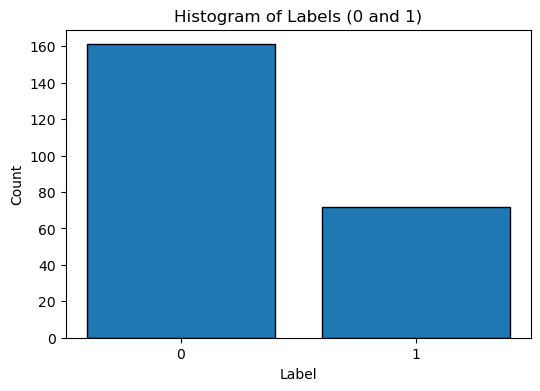

In [163]:
import matplotlib.pyplot as plt

# Plot histogram of the 'label' column
plt.figure(figsize=(6,4))
plt.hist(df_merged_filtered['label'], bins=[-0.5, 0.5, 1.5], edgecolor='black', rwidth=0.8)
plt.xticks([0, 1])
plt.xlabel('Label')
plt.ylabel('Count')
plt.title('Histogram of Labels (0 and 1)')
plt.show()
#class 1 is not in equal representation

In [170]:
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from imblearn.over_sampling import SMOTE

# Prepare feature matrix X and target vector y
X = df_merged_filtered[['blood_pressure']]  # feature(s) must be 2D
y = df_merged_filtered['label']             # target variable

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Apply SMOTE only on the training data to balance the classes

smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Initialize StandardScaler and scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_resampled)
X_test_scaled = scaler.transform(X_test)

# Create and train the logistic regression model
model = LogisticRegression(solver='liblinear', random_state=42)
model.fit(X_train_scaled, y_train_resampled)

# Predict on the test data
y_pred = model.predict(X_test_scaled)

# Evaluate model performance
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))



Accuracy: 0.5957446808510638
Confusion Matrix:
 [[22 10]
 [ 9  6]]
Classification Report:
               precision    recall  f1-score   support

           0       0.71      0.69      0.70        32
           1       0.38      0.40      0.39        15

    accuracy                           0.60        47
   macro avg       0.54      0.54      0.54        47
weighted avg       0.60      0.60      0.60        47



This logistic regression model 
currently shows moderate accuracy but 
struggles with detecting positive cases (class 1) reliably. 
    



In [165]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from imblearn.over_sampling import SMOTE

# Prepare feature matrix X and target vector y
X = df_merged_filtered[['blood_pressure']]
y = df_merged_filtered['label']

# Split data into training and testing sets with stratification
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Apply SMOTE to only training data to balance classes
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Initialize and train Decision Tree classifier on resampled data
dt_model = DecisionTreeClassifier(random_state=42)
dt_model.fit(X_train_resampled, y_train_resampled)

# Predict on the original test set
y_pred = dt_model.predict(X_test)

# Evaluate model performance
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("Classification Report:")
print(classification_report(y_test, y_pred))


Accuracy: 0.6809
Confusion Matrix:
[[25  7]
 [ 8  7]]
Classification Report:
              precision    recall  f1-score   support

           0       0.76      0.78      0.77        32
           1       0.50      0.47      0.48        15

    accuracy                           0.68        47
   macro avg       0.63      0.62      0.63        47
weighted avg       0.68      0.68      0.68        47



In [168]:
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold, train_test_split
from sklearn.metrics import classification_report

# Feature matrix and label vector
X = df_merged_filtered[['blood_pressure']]
y = df_merged_filtered['label']

# Split data into training and test sets (stratified)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Build a pipeline: SMOTE for oversampling, then Decision Tree using entropy
pipeline = Pipeline([
    ('smote', SMOTE(random_state=42)),
    ('clf', DecisionTreeClassifier(criterion='entropy', random_state=42))
])

# Define hyperparameter grid for tuning
param_grid = {
    'clf__max_depth': [3, 5, 10, None],
    'clf__min_samples_split': [2, 5, 10],
    'clf__min_samples_leaf': [1, 2, 4],
    'clf__max_features': [None, 'sqrt', 'log2']
}

# Define cross-validation strategy
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Initialize GridSearchCV
grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    cv=cv,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

# Fit GridSearchCV on training data
grid_search.fit(X_train, y_train)

# Output best hyperparameters and best score
print("Best hyperparameters:", grid_search.best_params_)
print(f"Best cross-validation accuracy: {grid_search.best_score_:.4f}")

# Use best estimator to predict on the test set
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

# Print classification report on test set
print("Classification Report on test set:")
print(classification_report(y_test, y_pred))


Fitting 5 folds for each of 108 candidates, totalling 540 fits
Best hyperparameters: {'clf__max_depth': 5, 'clf__max_features': None, 'clf__min_samples_leaf': 4, 'clf__min_samples_split': 2}
Best cross-validation accuracy: 0.7098
Classification Report on test set:
              precision    recall  f1-score   support

           0       0.76      0.50      0.60        32
           1       0.38      0.67      0.49        15

    accuracy                           0.55        47
   macro avg       0.57      0.58      0.55        47
weighted avg       0.64      0.55      0.57        47



The decision tree model outperforms logistic regression 
in predicting abnormal blood pressure, likely because decision trees
do not assume a linear relationship between features and the target. 
While logistic regression achieved an accuracy of around 60%, 
the decision tree reached higher cross-validation accuracy near 71%. 
Logistic regression’s reliance on a linear boundary means it may struggle 
with complex or nonlinear patterns inherent in blood pressure data. 
In contrast, decision trees can naturally capture nonlinear interactions 
and thresholds, leading to better predictive performance, especially for 
the minority (abnormal) class.
